In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import warnings

warnings.filterwarnings("ignore")
% matplotlib inline

In [65]:
features = pd.read_csv('temps.csv')

#看看数据长什么样子
features.head(5)
features.tail(5)

,year,month,day,week,temp_2,temp_1,average,actual,friend
343,2016,12,27,Tues,42,42,45.2,47,47
344,2016,12,28,Wed,42,47,45.3,48,58
345,2016,12,29,Thurs,47,48,45.3,48,65
346,2016,12,30,Fri,48,48,45.4,57,42
347,2016,12,31,Sat,48,57,45.5,40,57


数据表中
* year,moth,day,week分别表示的具体的时间
* temp_2：前天的最高温度值
* temp_1：昨天的最高温度值
* average：在历史中，每年这一天的平均最高温度值
* actual：这就是我们的标签值了，当天的真实最高温度
* friend：这一列可能是凑热闹的，你的朋友猜测的可能值，咱们不管它就好了

In [4]:
print('数据维度:', features.shape)

数据维度: (348, 9)


In [66]:
# 处理时间数据
import datetime

# 分别得到年，月，日
years = features['year']
months = features['month']
days = features['day']

# datetime格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

In [67]:
dates[:5]

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 1, 2, 0, 0),
 datetime.datetime(2016, 1, 3, 0, 0),
 datetime.datetime(2016, 1, 4, 0, 0),
 datetime.datetime(2016, 1, 5, 0, 0)]

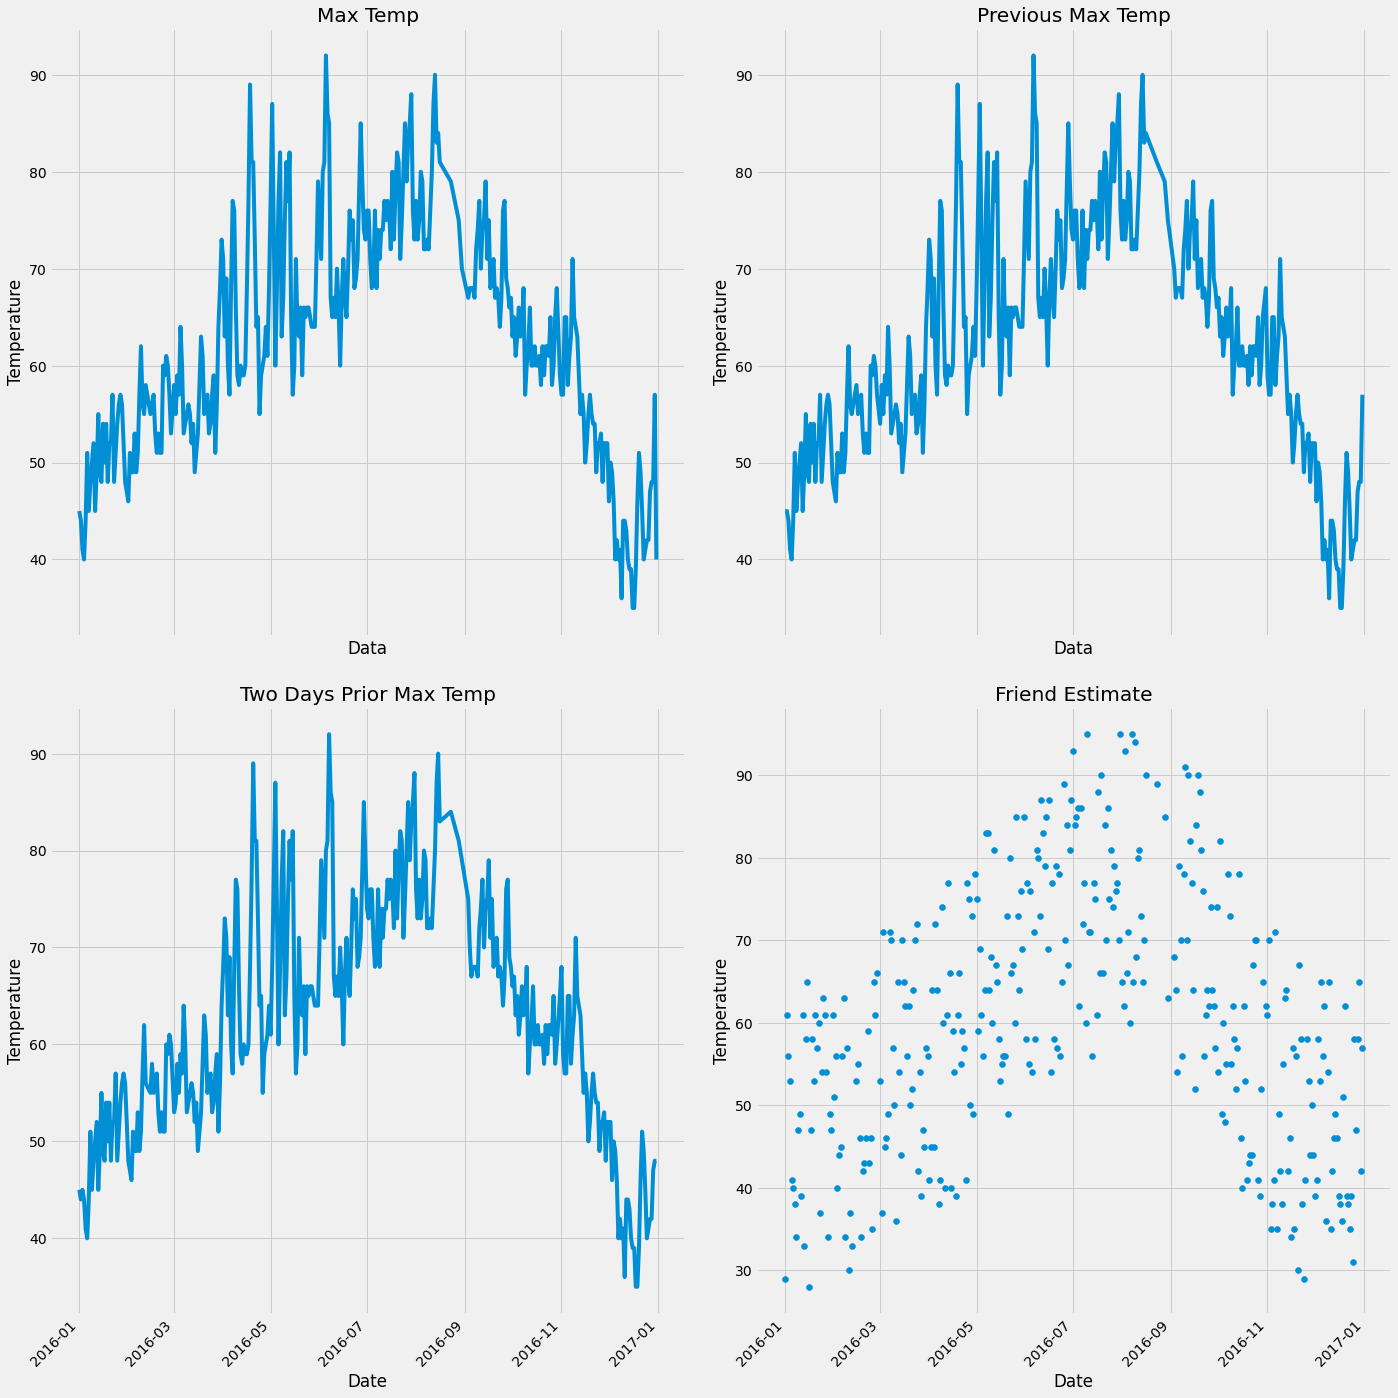

In [68]:
# 准备画图
# 指定默认风格
plt.style.use('fivethirtyeight')

# 设置布局
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
fig.autofmt_xdate(rotation=45)

# 标签值
ax1.plot(dates, features['actual'])
ax1.set_xlabel('Data')
ax1.set_ylabel('Temperature')
ax1.set_title('Max Temp')

# 昨天
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel('Data');
ax2.set_ylabel('Temperature');
ax2.set_title('Previous Max Temp')

# 前天
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date');
ax3.set_ylabel('Temperature');
ax3.set_title('Two Days Prior Max Temp')

# 我的逗逼朋友
ax4.scatter(dates, features['friend'])
ax4.set_xlabel('Date');
ax4.set_ylabel('Temperature');
ax4.set_title('Friend Estimate')

plt.tight_layout(pad=2)

In [69]:
# 独热编码
features = pd.get_dummies(features)
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,41,0,0,0,0,0,1,0


In [70]:
# 标签
labels = np.array(features['actual'])

# 在特征中去掉标签
features = features.drop('actual', axis=1)

# 名字单独保存一下，以备后患
feature_list = list(features.columns)

# 转换成合适的格式
features = np.array(features)

In [71]:
features.shape
#print(features.head(5))

(348, 14)

In [72]:
from sklearn import preprocessing

input_features = preprocessing.StandardScaler().fit_transform(features)

In [73]:
input_features[0]

array([ 0.        , -1.5678393 , -1.65682171, -1.48452388, -1.49443549,
       -1.3470703 , -1.98891668,  2.44131112, -0.40482045, -0.40961596,
       -0.40482045, -0.40482045, -0.41913682, -0.40482045])

### 构建网络模型

In [77]:
x = torch.tensor(input_features, dtype=float)

y = torch.tensor(labels, dtype=float)

# 权重参数初始化
weights = torch.randn((14, 128), dtype=float, requires_grad=True)
biases = torch.randn(128, dtype=float, requires_grad=True)
weights2 = torch.randn((128, 64), dtype=float, requires_grad=True)
biases2 = torch.randn(64, dtype=float, requires_grad=True)
weights3 = torch.randn((64, 1), dtype=float, requires_grad=True)
biases3 = torch.randn(1, dtype=float, requires_grad=True)

learning_rate = 0.001
losses = []

epoch = 10000


In [78]:
for i in range(epoch):
    # 计算隐层
    hidden = x.mm(weights) + biases
    # 加入激活函数
    hidden = torch.relu(hidden)
    hidden2 = hidden.mm(weights2) + biases2
    hidden2 = torch.relu(hidden2)
    #hidden2=
    # 预测结果
    predictions = hidden2.mm(weights3) + biases3
    # 通计算损失
    loss = torch.mean((predictions - y) ** 2)
    losses.append(loss.data.numpy())

    # 打印损失值
    if i % 100 == 0:
        print('loss:', loss)
    #返向传播计算
    loss.backward()

    #更新参数
    weights.data.add_(- learning_rate * weights.grad.data)
    biases.data.add_(- learning_rate * biases.grad.data)
    weights2.data.add_(- learning_rate * weights2.grad.data)
    biases2.data.add_(- learning_rate * biases2.grad.data)
    weights3.data.add_(- learning_rate * weights3.grad.data)
    biases3.data.add_(- learning_rate * biases3.grad.data)
    # 每次迭代都得记得清空
    weights.grad.data.zero_()
    biases.grad.data.zero_()
    weights2.grad.data.zero_()
    biases2.grad.data.zero_()
    weights3.grad.data.zero_()
    biases3.grad.data.zero_()

loss: tensor(62759.1503, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(nan, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(nan, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(nan, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(nan, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(nan, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(nan, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(nan, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(nan, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(nan, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(nan, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(nan, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(nan, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(nan, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(nan, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(nan, dtype=torch.flo

In [50]:
predictions.shape

torch.Size([348, 1])

### 更简单的构建网络模型

In [82]:
input_size = input_features.shape[1]
hidden_size = 256
hidden1_size = 256
hidden1_out = 256
output_size = 1
batch_size = 16
my_nn = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden1_size, hidden1_out),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden1_out, output_size),
)
cost = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(my_nn.parameters(), lr=0.001)

In [83]:
# 训练网络
losses = []
for i in range(1000):
    batch_loss = []
    # MINI-Batch方法来进行训练
    for start in range(0, len(input_features), batch_size):
        end = start + batch_size if start + batch_size < len(input_features) else len(input_features)
        xx = torch.tensor(input_features[start:end], dtype=torch.float, requires_grad=True)
        yy = torch.tensor(labels[start:end], dtype=torch.float, requires_grad=True)
        prediction = my_nn(xx)
        loss = cost(prediction, yy)
        optimizer.zero_grad()  #对梯度清零
        loss.backward(retain_graph=True)  #反向给传播
        optimizer.step()
        batch_loss.append(loss.data.numpy())  #记录损失

    # 打印损失
    if i % 100 == 0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))

0 3766.7263
100 33.10203
200 32.05477
300 31.540197
400 32.13154
500 31.21667
600 30.473194
700 30.327486
800 30.395887
900 30.398756


预测训练结果

In [85]:
x = torch.tensor(input_features, dtype=torch.float)
predict = my_nn(x).data.numpy()  #前向传播得到预测值

In [88]:
# 转换日期格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# 创建一个表格来存日期和其对应的标签数值
true_data = pd.DataFrame(data={'date': dates, 'actual': labels})
print(true_data)

# 同理，再创建一个来存日期和其对应的模型预测值
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]

test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in
              zip(years, months, days)]

test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

predictions_data = pd.DataFrame(data={'date': test_dates, 'prediction': predict.reshape(-1)})

          date  actual
0   2016-01-01      45
1   2016-01-02      44
2   2016-01-03      41
3   2016-01-04      40
4   2016-01-05      44
..         ...     ...
343 2016-12-27      47
344 2016-12-28      48
345 2016-12-29      48
346 2016-12-30      57
347 2016-12-31      40

[348 rows x 2 columns]


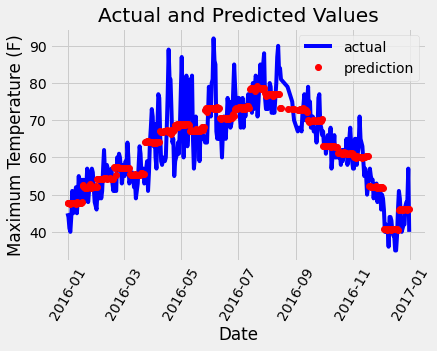

In [102]:
# 真实值
plt.plot(true_data['date'], true_data['actual'], 'b-', label='actual')

# 预测值
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label='prediction')
plt.xticks(rotation='60');
plt.legend()

# 图名
plt.xlabel('Date');
plt.ylabel('Maximum Temperature (F)');
plt.title('Actual and Predicted Values');
#plt.show()


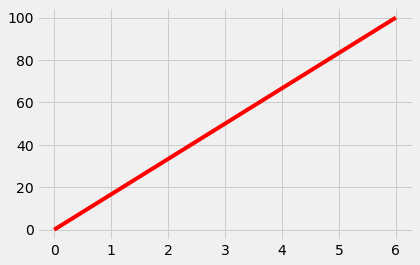

In [112]:
xpoints = np.array([0, 6])
ypoints = np.array([0, 100])

plt.plot(xpoints, ypoints, 'r')
plt.show()

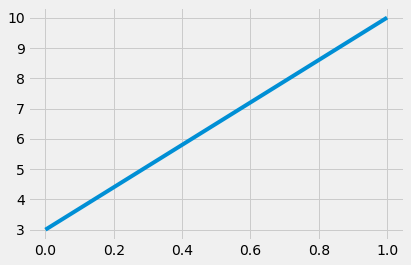

In [113]:
ypoints = np.array([3, 10])

plt.plot(ypoints)
plt.show()

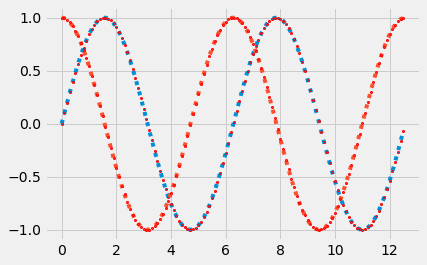

In [131]:
x = np.arange(0, 4 * np.pi, 0.1)  # start,stop,step
y = np.sin(x)
z = np.cos(x)
g = np.tan(x)
plt.plot(x, y, x, z, marker='o', ms=2, mec='r', linestyle='dotted')
#plt.plot(x,g)
plt.show()

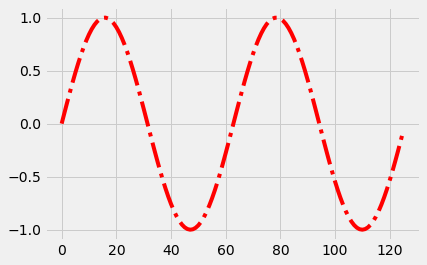

In [134]:
plt.plot(y, color='r', ls='-.')
plt.show()

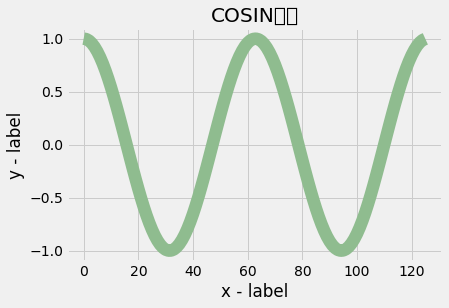

In [139]:
plt.plot(z, c='#8FBC8F', linewidth='12.5')
plt.xlabel("x - label")
plt.ylabel("y - label")
plt.title("COSIN函数")
plt.show()

In [141]:
import matplotlib

a = sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])

for i in a:
    print(i)

Adobe Heiti Std
Adobe Song Std
Arial
Arial
Arial
Arial
Arial
Bahnschrift
Calibri
Calibri
Calibri
Calibri
Calibri
Calibri
Cambria
Cambria
Cambria
Cambria
Candara
Candara
Candara
Candara
Candara
Candara
Comic Sans MS
Comic Sans MS
Comic Sans MS
Comic Sans MS
Consolas
Consolas
Consolas
Consolas
Constantia
Constantia
Constantia
Constantia
Corbel
Corbel
Corbel
Corbel
Corbel
Corbel
Courier New
Courier New
Courier New
Courier New
DejaVu Math TeX Gyre
DejaVu Sans
DejaVu Sans
DejaVu Sans
DejaVu Sans
DejaVu Sans Display
DejaVu Sans Mono
DejaVu Sans Mono
DejaVu Sans Mono
DejaVu Sans Mono
DejaVu Sans Mono
DejaVu Sans Mono
DejaVu Sans Mono
DejaVu Sans Mono
DejaVu Serif
DejaVu Serif
DejaVu Serif
DejaVu Serif
DejaVu Serif Display
DengXian
DengXian
DengXian
Ebrima
Ebrima
FangSong
Franklin Gothic Medium
Franklin Gothic Medium
Gabriola
Gadugi
Gadugi
Georgia
Georgia
Georgia
Georgia
HoloLens MDL2 Assets
Impact
Ink Free
Javanese Text
KaiTi
Leelawadee UI
Leelawadee UI
Leelawadee UI
Lucida Console
Lucida San

In [142]:
plt.rcParams['font.family'] = ['Microsoft YaHei']

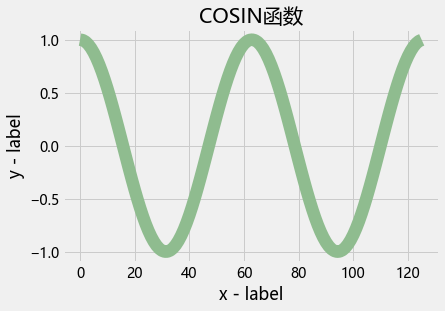

In [143]:
plt.plot(z, c='#8FBC8F', linewidth='12.5')
plt.xlabel("x - label")
plt.ylabel("y - label")
plt.title("COSIN函数")
plt.show()

In [144]:
"""title() 方法提供了 loc 参数来设置标题显示的位置，可以设置为: 'left', 'right', 和 'center'， 默认值为 'center'。

xlabel() 方法提供了 loc 参数来设置 x 轴显示的位置，可以设置为: 'left', 'right', 和 'center'， 默认值为 'center'。

ylabel() 方法提供了 loc 参数来设置 y 轴显示的位置，可以设置为: 'bottom', 'top', 和 'center'， 默认值为 'center'。
"""

"title() 方法提供了 loc 参数来设置标题显示的位置，可以设置为: 'left', 'right', 和 'center'， 默认值为 'center'。\n\nxlabel() 方法提供了 loc 参数来设置 x 轴显示的位置，可以设置为: 'left', 'right', 和 'center'， 默认值为 'center'。\n\nylabel() 方法提供了 loc 参数来设置 y 轴显示的位置，可以设置为: 'bottom', 'top', 和 'center'， 默认值为 'center'。\n"

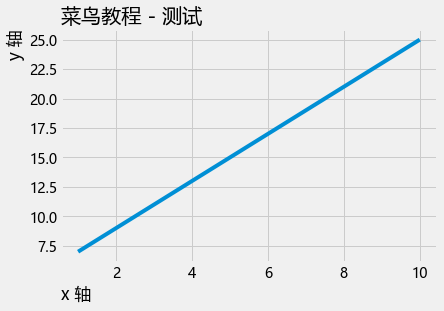

In [145]:
x = np.arange(1, 11)
y = 2 * x + 5

# fontdict 可以使用 css 来设置字体样式
plt.title("菜鸟教程 - 测试", loc="left")

# fontproperties 设置中文显示，fontsize 设置字体大小
plt.xlabel("x 轴", loc="left")
plt.ylabel("y 轴", loc="top")
plt.plot(x, y)
plt.show()

In [147]:
#我们可以使用 pyplot 中的 grid() 方法来设置图表中的网格线。

#grid() 方法语法格式如下：

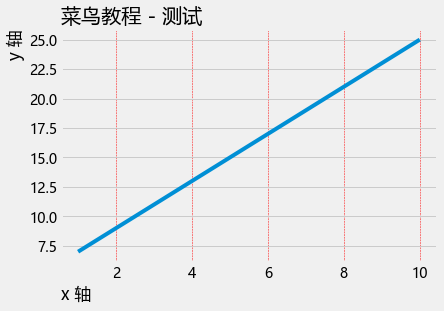

In [153]:


x = np.arange(1, 11)
y = 2 * x + 5

# fontdict 可以使用 css 来设置字体样式
plt.title("菜鸟教程 - 测试", loc="left")

# fontproperties 设置中文显示，fontsize 设置字体大小
plt.xlabel("x 轴", loc="left")
plt.ylabel("y 轴", loc="top")
plt.plot(x, y)
plt.grid(axis='x', color='r', linestyle='--', linewidth=0.5)  # 设置 y 就在轴方向显示网格线
plt.show()

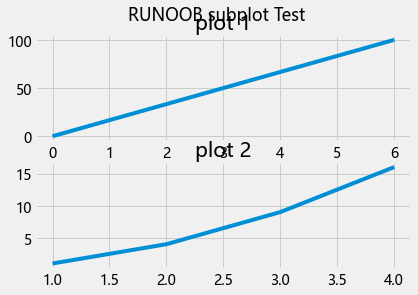

In [167]:
import matplotlib.pyplot as plt
import numpy as np

#plot 1:
xpoints = np.array([0, 6])
ypoints = np.array([0, 100])

plt.subplot(2, 1, 1)
plt.plot(xpoints, ypoints)
plt.title("plot 1")

#plot 2:
x = np.array([1, 2, 3, 4])
y = np.array([1, 4, 9, 16])

plt.subplot(2, 1, 2)
plt.plot(x, y)
plt.title("plot 2")

plt.suptitle("RUNOOB subplot Test")
plt.show()

In [168]:

# 创建一些测试数据 -- 图1
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)

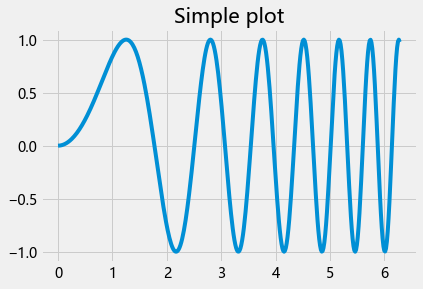

In [173]:
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_title('Simple plot')
plt.show()

Text(0.5, 0.98, '创建两个子图')

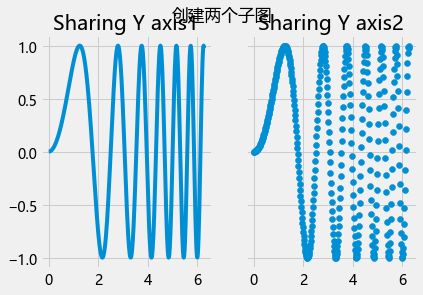

In [177]:
# 创建两个子图 -- 图3
fg, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(x, y)
ax1.set_title('Sharing Y axis1')
ax2.scatter(x, y)
ax2.set_title('Sharing Y axis2')
plt.suptitle("创建两个子图")

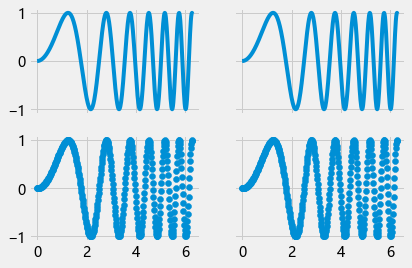

In [185]:
# fig, axs = plt.subplots(2, 2, subplot_kw=dict(projection="polar"))
# axs[0, 0].plot(x, y)
# axs[1, 1].scatter(x, y)
# 共享 x 轴
fig, ax = plt.subplots(2, 2, sharex='all', sharey='all')
ax[0, 0].plot(x, y)
ax[0, 1].plot(x, y)

ax[1, 0].scatter(x, y)
ax[1, 1].scatter(x, y)

plt.show()

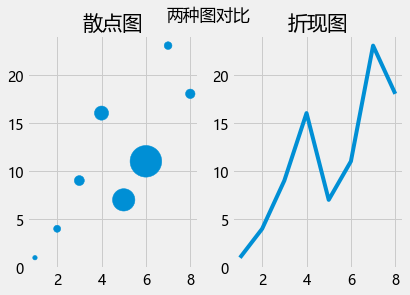

In [215]:
#我们可以使用 pyplot 中的 scatter() 方法来绘制散点图。

#scatter() 方法语法格式如下：
import matplotlib.pyplot as plt
import numpy as np

x = np.array([1, 2, 3, 4, 5, 6, 7, 8])
y = np.array([1, 4, 9, 16, 7, 11, 23, 18])
sizes = np.array([20,50,100,200,500,1000,60,90])

fg, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(x, y ,s=sizes)
ax1.set_title('散点图')

ax2.plot(x, y)
ax2.set_title('折现图')
plt.suptitle("两种图对比")
plt.show()


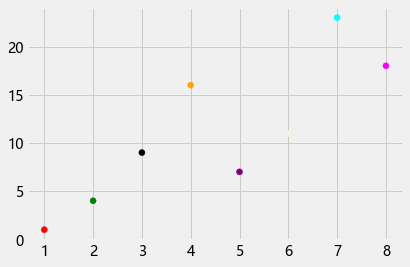

In [216]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array([1, 2, 3, 4, 5, 6, 7, 8])
y = np.array([1, 4, 9, 16, 7, 11, 23, 18])
colors = np.array(["red","green","black","orange","purple","beige","cyan","magenta"])

plt.scatter(x, y, c=colors)
plt.show()

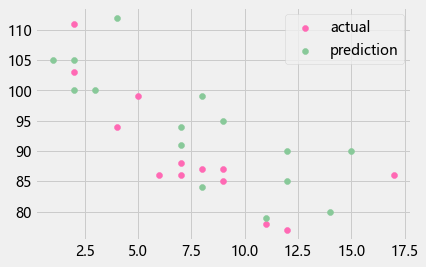

In [218]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array([5,7,8,7,2,17,2,9,4,11,12,9,6])
y = np.array([99,86,87,88,111,86,103,87,94,78,77,85,86])
plt.scatter(x, y, color = 'hotpink',label='actual')


x = np.array([2,2,8,1,15,8,12,9,7,3,11,4,7,14,12])
y = np.array([100,105,84,105,90,99,90,95,94,100,79,112,91,80,85])
plt.scatter(x, y, color = '#88c999',label='prediction')
plt.legend()
plt.show()

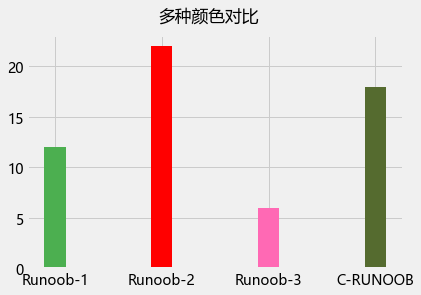

In [221]:
x = np.array(["Runoob-1", "Runoob-2", "Runoob-3", "C-RUNOOB"])
y = np.array([12, 22, 6, 18])

plt.bar(x, y,  color = ["#4CAF50","red","hotpink","#556B2F"],width = 0.2)
plt.suptitle("多种颜色对比")
plt.show()

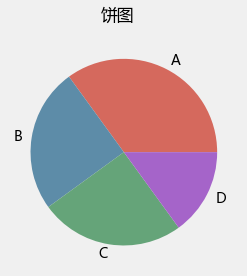

In [224]:
y = np.array([35, 25, 25, 15])

plt.pie(y,
        labels=['A','B','C','D'], # 设置饼图标签
        colors=["#d5695d", "#5d8ca8", "#65a479", "#a564c9"], # 设置饼图颜色
       )
plt.suptitle('饼图') # 设置标题
plt.show()